In [16]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
%matplotlib inline
from collections import Counter
import sklearn.cross_validation
import math
import time
pd.set_option('display.max_columns', None)
from scipy import stats
from sklearn.linear_model import RandomizedLasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#from sklearn.pls import PLSRegression
import sys
#from pyearth import Earth

In [17]:
filename = "data_sci_snippet.csv.zip"
zf = zipfile.ZipFile(filename, 'r')
print zf.namelist()

['data_sci_snippet.csv']


In [63]:
def time_preprocessing(df, column_name):
    
    times = []
    count = 0
    start = time.time()
    for i in df[column_name]:
        count += 1
        if count % 100000 == 0:
            time_elapsed = time.time() - start
            #print "Count = %r, Time Elapsed = %r" %(count, time_elapsed)
        times.append(time.strptime(i, "%Y-%m-%d"))

    year = []
    month = []
    day = []
    day_of_week = []
    day_in_year = []

    for i in times:
        year.append(i[0])
        month.append(i[1])
        day.append(i[2])
        day_of_week.append(i[6])
        day_in_year.append(i[7])
    df[column_name + ' year'] = year
    df[column_name + ' month'] = month
    df[column_name + ' day'] = day
    df[column_name + ' day_of_week'] = day_of_week
    df[column_name + ' day_in_year'] = day_in_year
    df.drop([column_name], axis=1)
    return df

In [77]:
data = pd.read_csv(zf.open('data_sci_snippet.csv'))

one_hot_columns = ['Pool','ListingStatus','DwellingType']
count = 0
for i in one_hot_columns:
    dummies = pd.get_dummies(data[i])
    for j in dummies:
        data[j] = dummies[j]
        count += 1

data = time_preprocessing(data, 'ListDate')
data = data.dropna()

# Note that we won't have closedate in our test data
# Could still build a model for closing date and use that as a feature
#data = time_preprocessing(data, 'CloseDate')
data = data.drop(['CloseDate'], 1)

# Remove Outliers
data = data[(data['ClosePrice'] > 10000)]
#data = data[(data['ClosePrice'] < 500000)]
data = data[(data['ListPrice'] <= 7000000)]

print data.shape
data[:5]

(37502, 37)


,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,PublicRemarks,ClosePrice,ListingStatus,DwellingType,Both Private & Community,Community,None,Private,Active,Cancelled,Closed,Expired,Pending,Temp Off Market,Apartment Style/Flat,Gemini/Twin Home,Loft Style,Mfg/Mobile Housing,Modular/Pre-Fab,Patio Home,Single Family - Detached,Townhouse,ListDate year,ListDate month,ListDate day,ListDate day_of_week,ListDate day_in_year
1,5077408,2230,4,2.0,Private,1,2014-03-01,475000,33.650984,-111.963151,Very special home in popular Arabian Views fee...,460000,Closed,Single Family - Detached,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2014,3,1,5,60
2,5077486,1601,3,2.0,Private,1,2014-03-01,279900,33.692122,-112.038019,Welcome home to a beautiful remodeled. Single ...,279900,Closed,Single Family - Detached,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2014,3,1,5,60
3,5077487,2440,4,2.5,None,2,2014-03-01,229900,33.647270,-112.251490,"NO HOA!! MOVE-IN READY!! Location, Condition ...",228000,Closed,Single Family - Detached,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2014,3,1,5,60
4,5077489,3980,5,3.0,None,1,2014-03-01,385250,33.389139,-111.712757,Price reduced to under $100 per square foot! F...,385250,Closed,Single Family - Detached,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2014,3,1,5,60
5,5077490,1243,3,2.0,None,1,2014-03-01,155000,33.403250,-111.771918,Stunning 3 bedroom Mesa AZ home located in the...,159000,Closed,Single Family - Detached,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2014,3,1,5,60


In [78]:
data = data.drop(['Pool', 'ListingStatus', 'DwellingType', 'ListDate', 'PublicRemarks', 'ListDate year'], axis=1)

In [79]:
data['ListPrice'] = np.log(data['ListPrice'])
data['ClosePrice'] = np.log(data['ClosePrice'])
preprocessing_array = []
for i in data:
    if i == 'ClosePrice':
        closeprice_mean = data[i].mean()
        closeprice_std = data[i].std()
    preprocessing_array.append([i, data[i].mean(), data[i].std()])
    data[i] = data[i] - data[i].mean()
    data[i] = data[i]/float(data[i].std())

def unprocess(data, mean = closeprice_mean, std = closeprice_std):
    return np.exp(data*closeprice_std+closeprice_mean)

In [80]:
y = data['ClosePrice']
x = data.drop(['ClosePrice'], 1)
columns = data.columns
x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    x, y, test_size=0.02, random_state=42)

print x_train.shape
print x_test.shape
print y_train.shape
print y_test.shape

(36751, 30)
(751, 30)
(36751,)
(751,)


In [81]:
data = pd.DataFrame(x_train, columns=columns[:-1])
data['ClosePrice'] = y_train
test_data = pd.DataFrame(x_test, columns=columns[:-1])
test_data['ClosePrice'] = y_test

In [82]:
full = pd.DataFrame()
for_test = pd.DataFrame()
for i in data:
    for j in data:
        if i != 'ClosePrice' and j != 'ClosePrice':
            full[i + '*' + j] = data[i]*data[j]
            for_test[i + '*' + j] = test_data[i]*test_data[j]
full['ClosePrice'] = data['ClosePrice']
correlations = full.corrwith(full['ClosePrice'])
columns = full.columns
for i in range(len(correlations)):
    if abs(list(correlations)[i]) > .3:
        data[columns[i]] = full[columns[i]]
        if columns[i] != 'ClosePrice':
            test_data[columns[i]] = for_test[columns[i]]

In [83]:
data[:5]

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice,Both Private & Community,Community,None,Private,Active,Cancelled,Closed,Expired,Pending,Temp Off Market,Apartment Style/Flat,Gemini/Twin Home,Loft Style,Mfg/Mobile Housing,Modular/Pre-Fab,Patio Home,Single Family - Detached,Townhouse,ListDate month,ListDate day,ListDate day_of_week,ListPrice*Single Family - Detached,Community*None,None*Community,Private*Private,Apartment Style/Flat*Mfg/Mobile Housing,Apartment Style/Flat*Townhouse,Mfg/Mobile Housing*Apartment Style/Flat,Single Family - Detached*ListPrice,Single Family - Detached*Single Family - Detached,Townhouse*Apartment Style/Flat
14872,-0.819346,-0.348713,0.829562,0.079004,-0.417658,-0.129661,0.267720,-0.175560,-0.121498,-0.195455,-0.579539,1.076039,-0.574818,-0.039357,-0.057829,0.0907,-0.033881,-0.045062,-0.010328,-0.221703,-0.083067,-0.027819,-0.138415,-0.020659,-0.116125,0.428772,-0.270727,-0.771474,-0.489015,0.770380,-0.055595,-0.623607,-0.623607,0.330415,0.030687,0.060021,0.030687,-0.055595,0.183845,0.060021
41742,0.812407,-0.249091,-1.364854,-0.094903,-0.417658,-0.220623,0.716092,-1.176647,-0.176578,-0.195455,1.725464,-0.929309,-0.574818,-0.039357,-0.057829,0.0907,-0.033881,-0.045062,-0.010328,-0.221703,-0.083067,-0.027819,-0.138415,-0.020659,8.611175,-2.332182,-0.270727,0.989726,-0.828447,-0.969994,0.514533,-1.603489,-1.603489,0.330415,0.030687,0.060021,0.030687,0.514533,5.439072,0.060021
35680,0.434557,0.151857,-0.267646,0.035527,0.827216,0.198130,-0.735644,0.670452,0.226970,-0.195455,1.725464,-0.929309,-0.574818,-0.039357,-0.057829,0.0907,-0.033881,-0.045062,-0.010328,-0.221703,-0.083067,-0.027819,-0.138415,-0.020659,-0.116125,0.428772,-0.270727,0.402659,0.076704,-1.550119,0.084953,-1.603489,-1.603489,0.330415,0.030687,0.060021,0.030687,0.084953,0.183845,0.060021
36944,0.513902,-0.108882,-0.267646,-0.051426,-0.417658,1.800493,0.155105,-0.049732,1.816354,-0.195455,-0.579539,1.076039,-0.574818,-0.039357,-0.057829,0.0907,-0.033881,-0.045062,-0.010328,-0.221703,-0.083067,-0.027819,-0.138415,-0.020659,-0.116125,0.428772,-0.270727,0.402659,0.529280,0.770380,0.772000,-0.623607,-0.623607,0.330415,0.030687,0.060021,0.030687,0.772000,0.183845,0.060021
23666,-0.302506,-0.513520,-0.267646,-0.051426,-0.417658,-0.341752,-0.239134,0.975207,-0.272642,-0.195455,-0.579539,-0.929309,1.739635,-0.039357,-0.057829,0.0907,-0.033881,-0.045062,-0.010328,-0.221703,-0.083067,-0.027819,-0.138415,-0.020659,-0.116125,0.428772,-0.270727,-0.184407,-0.828447,0.190255,-0.146534,0.538571,0.538571,3.026331,0.030687,0.060021,0.030687,-0.146534,0.183845,0.060021


In [71]:
columns = []
for i in data:
    if '*' in i:
        columns.append(i)

In [72]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [73]:
# Look at linear relationship strength
data.corr()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice,Both Private & Community,Community,None,Private,Active,Cancelled,Closed,Expired,Pending,Temp Off Market,Apartment Style/Flat,Gemini/Twin Home,Loft Style,Mfg/Mobile Housing,Modular/Pre-Fab,Patio Home,Single Family - Detached,Townhouse,ListDate month,ListDate day,ListDate day_of_week,ListPrice*ListPrice,ListPrice*Single Family - Detached,Community*None,None*Community,Private*Private,Apartment Style/Flat*Mfg/Mobile Housing,Apartment Style/Flat*Townhouse,Mfg/Mobile Housing*Apartment Style/Flat,Mfg/Mobile Housing*Townhouse,Single Family - Detached*ListPrice,Single Family - Detached*Single Family - Detached,Townhouse*Apartment Style/Flat,Townhouse*Mfg/Mobile Housing
ListingId,1.000000,-0.019523,0.002934,-0.010933,-0.007162,-0.017207,-0.006554,-0.000102,-0.016413,-0.014129,-0.021110,0.024751,-0.001627,0.019215,0.007919,-0.029096,0.008274,0.024007,0.004901,-0.012632,-0.002128,-0.003118,-0.003462,0.001408,-0.010654,0.008985,0.005330,0.984156,0.172033,0.016231,-0.008390,-0.006752,0.007156,0.007156,-0.001627,0.009825,0.006629,0.009825,0.000642,-0.006752,-0.008985,0.006629,0.000642
LivingArea,-0.019523,1.000000,0.708182,0.060576,0.120028,0.671364,-0.066662,-0.023232,0.669955,0.099765,-0.243287,-0.069729,0.296037,0.012273,-0.002757,-0.003668,0.005863,-0.005802,0.004978,-0.267514,-0.053568,-0.027942,-0.108098,-0.014259,-0.072001,0.378756,-0.205615,-0.018278,-0.006408,0.011776,-0.081320,-0.166151,0.347842,0.347842,0.296037,0.237905,0.348103,0.237905,0.193488,-0.166151,-0.378756,0.348103,0.193488
NumBedrooms,0.002934,0.708182,1.000000,0.054986,0.032706,0.441276,-0.131512,-0.009013,0.446900,0.023117,-0.433151,0.127540,0.290906,0.013212,-0.000354,-0.009419,0.007229,-0.000279,0.009723,-0.353027,-0.104547,-0.057454,-0.090256,-0.007791,-0.118957,0.483043,-0.252382,0.003700,-0.003382,0.024353,-0.162489,-0.240247,0.431148,0.431148,0.290906,0.269022,0.447011,0.269022,0.199173,-0.240247,-0.483043,0.447011,0.199173
NumBaths,-0.010933,0.060576,0.054986,1.000000,0.016708,0.040249,-0.004025,-0.002607,0.041173,0.004507,-0.013866,0.000061,0.012556,0.000305,-0.000640,0.000924,-0.000179,-0.001304,0.000491,-0.022534,-0.005435,-0.002189,-0.008328,-0.001380,-0.005493,0.025535,-0.008566,-0.009376,-0.007321,0.009053,-0.011308,-0.019576,0.016809,0.016809,0.012556,0.019373,0.023613,0.019373,0.011515,-0.019576,-0.025535,0.023613,0.011515
ExteriorStories,-0.007162,0.120028,0.032706,0.016708,1.000000,0.034583,-0.010043,0.022049,0.032553,0.023803,0.162155,-0.134735,-0.018708,0.004138,0.008474,-0.008313,-0.000131,0.000935,0.005633,0.243309,-0.034404,0.296125,-0.059658,-0.009160,-0.037350,-0.213564,0.131691,-0.006974,-0.004740,0.001324,0.016036,0.047244,-0.096374,-0.096374,-0.018708,-0.080910,-0.280526,-0.080910,-0.007501,0.047244,0.213564,-0.280526,-0.007501
ListPrice,-0.017207,0.671364,0.441276,0.040249,0.034583,1.000000,0.084656,0.092362,0.995359,0.116021,-0.162530,-0.176572,0.332195,-0.007508,-0.023521,0.030097,-0.010047,-0.015469,-0.002576,-0.247023,-0.080127,0.014409,-0.228400,-0.033946,-0.015001,0.388159,-0.190841,-0.014411,-0.006503,0.047040,-0.375257,-0.390841,0.329556,0.329556,0.332195,0.329947,0.322075,0.329947,0.295266,-0.390841,-0.388159,0.322075,0.295266
GeoLat,-0.006554,-0.066662,-0.131512,-0.004025,-0.010043,0.084656,1.000000,-0.273006,0.079501,-0.003029,0.014331,0.002634,-0.016852,0.010451,-0.005725,0.003221,-0.005213,-0.003610,-0.003355,0.060569,0.032802,0.002801,0.029295,0.007346,0.015396,-0.077546,0.025762,-0.007320,-0.008043,-0.019047,0.018152,0.048853,-0.019388,-0.019388,-0.016852,-0.057999,-0.065255,-0.057999,-0.038470,0.048853,0.077546,-0.065255,-0.038470
GeoLon,-0.000102,-0.023232,-0.009013,-0.002607,0.022049,0.092362,-0.273006,1.000000,0.087018,-0.005615,0.033962,-0.038838,0.013052,-0.008539,-0.014850,0.015422,-0.009956,0.003348,0.000169,-0.002223,-0.049620,-0.004319,0.061878,0.012405,0.013428,-0.044021,0.041148,-0.003800,0.014021,0.008650,0.022536,0.002

In [76]:
# Split Training and Testing Data

x_train_listprice = data[[
                    'LivingArea',
                    'NumBedrooms',
                    'NumBaths',
                    'ExteriorStories',
                    'ListPrice',
                    'GeoLat',
                    'GeoLon',
                    'Both Private & Community',
                    'Private',
                    'Apartment Style/Flat',
                    'Gemini/Twin Home',
                    'Single Family - Detached',
                    'Townhouse',             
               ]]
for i in columns:
    x_train_listprice[i] = data[i]
    
y_train = data['ClosePrice']

x_test_listprice = test_data[[
                    'LivingArea',
                    'NumBedrooms',
                    'NumBaths',
                    'ExteriorStories',
                    'ListPrice',
                    'GeoLat',
                    'GeoLon',
                    'Both Private & Community',
                    'Private',
                    'Apartment Style/Flat',
                    'Gemini/Twin Home',
                    'Single Family - Detached',
                    'Townhouse',
                     
                   ]]
for i in columns:
    x_train_listprice[i] = test_data[i]
y_test = test_data['ClosePrice']

# Split Training and Testing Data

# x_train = data[[
#                     'LivingArea',
#                     'NumBedrooms',
#                     'NumBaths',
#                     'ExteriorStories',
# #                    'ListPrice',
#                     'GeoLat',
#                     'GeoLon',
#                     'Both Private & Community',
#                     'Private',
#                     'Apartment Style/Flat',
#                     'Gemini/Twin Home',
#                     'Single Family - Detached','Townhouse',
#                  'Both Private & Community*Community',
#                  'Community*Both Private & Community',
#                  'None*None',
#                  'Temp Off Market*Loft Style',
#                  'Temp Off Market*Single Family - Detached',
#                  'Loft Style*Temp Off Market',
# #                'Patio Home*ListPrice',
#                  'Patio Home*Patio Home',
#                  'Single Family - Detached*Temp Off Market'
#                ]]
# y_train = data['ClosePrice']

# x_test = test_data[[
#                     'LivingArea',
#                     'NumBedrooms',
#                     'NumBaths',
#                     'ExteriorStories',
#                     'ListPrice',
#                     'GeoLat',
#                     'GeoLon',
#                     'Both Private & Community',
#                     'Private',
#                     'Apartment Style/Flat',
#                     'Gemini/Twin Home',
#                     'Single Family - Detached','Townhouse',
#                  'Both Private & Community*Community',
#                  'Community*Both Private & Community',
#                  'None*None',
#                  'Temp Off Market*Loft Style',
#                  'Temp Off Market*Single Family - Detached',
#                  'Loft Style*Temp Off Market',
#                 'Patio Home*ListPrice',
#                  'Patio Home*Patio Home',
#                  'Single Family - Detached*Temp Off Market'
#                    ]]
# y_test = test_data['ClosePrice']

/Users/jeremynixon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jeremynixon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
adjusted_y_test = unprocess(y_test)

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
%matplotlib inline
from collections import Counter
import sklearn.cross_validation
import math
import time
pd.set_option('display.max_columns', None)
from scipy import stats
from sklearn.linear_model import RandomizedLasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.pls import PLSRegression
import sys

def model_suite(x_train, y_train, x_test, y_test):
    predictions = []
    
    lasso = linear_model.Lasso()
    lasso.fit(x_train, y_train)
    predictions.append(['Lasso', lasso.predict(x_test)])
    print 'Lasso Complete.'
    sys.stdout.flush()
    
    elastic = linear_model.ElasticNet()
    elastic.fit(x_train, y_train)
    predictions.append(['Elastic Net', elastic.predict(x_test)]) 
    print 'Elastic Net Complete.'
    sys.stdout.flush()
    
    ridge = linear_model.Ridge()
    ridge.fit(x_train, y_train)
    predictions.append(['Ridge Regression', ridge.predict(x_test)]) 
    print 'Ridge Regression Complete.'
    sys.stdout.flush()
    
    bayesian_ridge = linear_model.BayesianRidge()
    bayesian_ridge.fit(x_train, y_train)
    predictions.append(['Bayesian Ridge', bayesian_ridge.predict(x_test)])
    print 'Bayesian Ridge Regression Complete.'
    sys.stdout.flush()
    
    pls = PLSRegression(n_components=3)
    pls.fit(x_train, y_train)
    pls_predictions = pls.predict(x_test)
    pls_predictions = pls_predictions.reshape(len(pls_predictions),)
    predictions.append(['Partial Least Squares', pls_predictions])
    print 'Partial Least Squares Regression Complete.'
    sys.stdout.flush()
    
    svr_rbf = svm.SVR(kernel = 'rbf')
    svr_rbf.fit(x_train, y_train)
    predictions.append(['SVR rbf', svr_rbf.predict(x_test)])
    print 'Support Vector Regressor RBF Kernel Complete.'
    sys.stdout.flush()
    
    svr_linear = svm.SVR(kernel = 'linear')
    svr_linear.fit(x_train, y_train)
    predictions.append(['SVR linear', svr_linear.predict(x_test)])
    print 'Support Vector Regressor Linear Kernel Complete.'
    sys.stdout.flush()
    
    svr_poly = svm.SVR(kernel = 'poly')
    svr_poly.fit(x_train, y_train)
    predictions.append(['SVR poly', svr_poly.predict(x_test)])
    print 'Support Vector Regressor Poly Kernel Complete.'
    sys.stdout.flush()
    
    forest = ensemble.RandomForestRegressor(n_estimators = 100)
    forest.fit(x_train, y_train)
    predictions.append(['Forest', forest.predict(x_test)]) 
    print 'Random Forest Regressor Complete.'
    sys.stdout.flush()

    extra = ensemble.ExtraTreesRegressor(n_estimators=100)
    extra.fit(x_train, y_train)
    predictions.append(['Extremely Random Forest', extra.predict(x_test)])
    print 'Extremely Random Forest Complete.'
    sys.stdout.flush()
    
    booster = ensemble.GradientBoostingRegressor(n_estimators = 100)
    booster.fit(x_train, y_train)
    predictions.append(['Booster', booster.predict(x_test)])
    print 'Gradient Boosted Trees Complete.'
    sys.stdout.flush()
    
    return predictions
start = time.time()
predictions = model_suite(x_train_listprice, y_train, x_test_listprice, y_test)
print time.time()-start

In [363]:
adjusted_y_test = unprocess(y_test)
for i in range(len(predictions)):
    print predictions[i][0]
    adjusted = unprocess(predictions[i][1])
    print "%r MAE = %r" %(predictions[i][0], abs(adjusted-adjusted_y_test).mean())
    print "%r Median = %r" %(predictions[i][0], np.median(abs(adjusted-adjusted_y_test)))

Lasso
'Lasso' MAE = 75562.281058661902
'Lasso' Median = 58019.058305274055
Elastic Net
'Elastic Net' MAE = 51198.878428421907
'Elastic Net' Median = 37513.160794522526
Ridge Regression
'Ridge Regression' MAE = 4833.3679624511497
'Ridge Regression' Median = 3489.2171417763457
Bayesian Ridge
'Bayesian Ridge' MAE = 4833.3245043723746
'Bayesian Ridge' Median = 3490.4813745429856
Partial Least Squares
'Partial Least Squares' MAE = 16743.250694576396
'Partial Least Squares' Median = 10741.898874746839
SVR rbf
'SVR rbf' MAE = 75675.807980980797
'SVR rbf' Median = 58733.953825992925
SVR linear
'SVR linear' MAE = 79555.377622543558
'SVR linear' Median = 60007.53183441273
SVR poly
'SVR poly' MAE = 111806.9524119267
'SVR poly' Median = 68305.169244001372
Forest
'Forest' MAE = 16616.470587350825
'Forest' Median = 6610.8684200421412
Extremely Random Forest
'Extremely Random Forest' MAE = 28985.177399199289
'Extremely Random Forest' Median = 11638.462176557936
Booster
'Booster' MAE = 20191.980998685

In [351]:
ensemble = ['Ridge Regression','Bayesian Ridge']
count = 0
combined_predictions = [0]*len(predictions[0][1])
for i in range(len(predictions)):
    if predictions[i][0] in ensemble:
        count += 1
        combined_predictions += predictions[i][1]
final_predictions = combined_predictions/count
final_predictions = unprocess(final_predictions)
adjusted = final_predictions
print abs(adjusted-adjusted_y_test).mean()
print np.median(abs(adjusted-adjusted_y_test))

5139.29008841
3479.08787996


In [352]:
ensemble = ['Bayesian Ridge', 'Booster']
count = 0
combined_predictions = [0]*len(predictions[0][1])
for i in range(len(predictions)):
    if predictions[i][0] in ensemble:
        count += 1
        combined_predictions += predictions[i][1]
final_predictions = combined_predictions/count
final_predictions = unprocess(final_predictions)
adjusted = final_predictions
print abs(adjusted-adjusted_y_test).mean()
print np.median(abs(adjusted-adjusted_y_test))

11870.2176264
4835.25732526


In [301]:
svr = svm.SVR(kernel = rbf)
svr.fit(x_train_listprice, y_train)
svr_predictions = svr.predict(x_test_listprice)

In [302]:
adjusted_svr_predictions = unprocess(svr_predictions)
print abs(adjusted_svr_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_svr_predictions-adjusted_y_test))

76394.4146828
65035.7129826


In [298]:
pls = PLSRegression(n_components=5)
pls.fit(x_train_listprice, y_train)
pls_predictions = pls.predict(x_test_listprice)
pls_predictions = pls_predictions.reshape(len(pls_predictions),)
adjusted_pls_predictions = unprocess(pls_predictions)
print abs(adjusted_pls_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_pls_predictions-adjusted_y_test))

76654.4455513
58454.6164124


In [211]:
lasso = linear_model.Lasso()
lasso.fit(x_train_listprice, y_train)
lasso_predictions = lasso.predict(x_test_listprice)
adjusted_lasso_predictions = unprocess(lasso_predictions)
print abs(adjusted_lasso_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_lasso_predictions-adjusted_y_test))

76058.1575217
58911.0595624


In [212]:
elastic = linear_model.ElasticNet()
elastic.fit(x_train_listprice, y_train)
elastic_predictions = elastic.predict(x_test_listprice)
adjusted_elastic_predictions = unprocess(elastic_predictions)
print abs(adjusted_elastic_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_elastic_predictions-adjusted_y_test))

51842.2903295
37481.8890476


In [ ]:
ridge = linear_model.Ridge()
ridge.fit(x_train_listprice, y_train)
ridge_predictions = ridge.predict(x_test_listprice)

In [ ]:
adjusted_ridge_predictions = unprocess(ridge_predictions)
print abs(adjusted_ridge_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_ridge_predictions-adjusted_y_test))

In [245]:
bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(x_train_listprice, y_train)
bayesian_ridge_predictions = bayesian_ridge.predict(x_test_listprice)

In [246]:
adjusted_bayesian_ridge_predictions = unprocess(bayesian_ridge_predictions)
print abs(adjusted_bayesian_ridge_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_bayesian_ridge_predictions-adjusted_y_test))

5139.34580862
3477.86791424


In [239]:
forest = ensemble.RandomForestRegressor(n_estimators = 1000)
forest.fit(x_train_listprice, y_train)
forest_predictions = forest.predict(x_test_listprice)

In [240]:
adjusted_forest_predictions = unprocess(forest_predictions)
adjusted_y_test = unprocess(y_test)
print abs(adjusted_forest_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_forest_predictions-adjusted_y_test))

5346.48582407
3667.61869624


In [336]:
booster = ensemble.GradientBoostingRegressor(n_estimators = 1000)
booster.fit(x_train_listprice, y_train)
booster_predictions = booster.predict(x_test_listprice)

In [337]:
adjusted_booster_predictions = unprocess(booster_predictions)
adjusted_y_test = unprocess(y_test)
print abs(adjusted_booster_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_booster_predictions-adjusted_y_test))

18574.8960158
6529.11654517


In [162]:
rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(x_train, y_train)

RandomizedLasso(alpha=0.025, eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=500, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

In [168]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(x_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, normalize=False),
  estimator_params={}, n_features_to_select=1, step=1, verbose=0)

In [172]:
for i in range(len(rfe.ranking_)):
    print(x_train.columns[i],list(rfe.ranking_)[i])

('LivingArea', 7)
('NumBedrooms', 5)
('NumBaths', 18)
('ExteriorStories', 20)
('ListPrice', 3)
('GeoLat', 14)
('GeoLon', 13)
('Both Private & Community', 11)
('Private', 6)
('Apartment Style/Flat', 21)
('Gemini/Twin Home', 19)
('Single Family - Detached', 16)
('Townhouse', 22)
('Both Private & Community*Community', 10)
('Community*Both Private & Community', 15)
('None*None', 17)
('Temp Off Market*Loft Style', 1)
('Temp Off Market*Single Family - Detached', 9)
('Loft Style*Temp Off Market', 2)
('Patio Home*ListPrice', 4)
('Patio Home*Patio Home', 12)
('Single Family - Detached*Temp Off Market', 8)


In [229]:
for i in range(len(forest.feature_importances_)):
    print(x_train_listprice.columns[i],list(forest.feature_importances_)[i])

('LivingArea', 0.0016794835184023218)
('NumBedrooms', 0.00028543326856058764)
('NumBaths', 0.0003548798890229264)
('ExteriorStories', 0.00013923075186613384)
('ListPrice', 0.99156155707467986)
('GeoLat', 0.0016258250549617372)
('GeoLon', 0.0018161923523261764)
('Both Private & Community', 5.5995243396190343e-05)
('Private', 4.5959293321998436e-05)
('Apartment Style/Flat', 2.2598568058683645e-05)
('Gemini/Twin Home', 6.3889358775157266e-06)
('Single Family - Detached', 3.2298257241907193e-05)
('Townhouse', 0.00055943204042675039)
('Both Private & Community*Community', 8.8784374684049041e-05)
('Community*Both Private & Community', 9.1317223046607016e-05)
('None*None', 0.00011989040825071763)
('Temp Off Market*Loft Style', 5.8968786406275096e-05)
('Temp Off Market*Single Family - Detached', 3.2179062238205669e-05)
('Loft Style*Temp Off Market', 5.3846630405726995e-05)
('Patio Home*ListPrice', 0.0013003452780402777)
('Patio Home*Patio Home', 3.858882361113285e-05)
('Single Family - Detache

5377.14132625
3611.20589043


In [193]:
print np.median(abs(adjusted_forest_predictions-adjusted_y_test))
print np.median(abs(adjusted_ridge_predictions-adjusted_y_test))
print np.median(abs((adjusted_forest_predictions+adjusted_ridge_predictions)/2-adjusted_y_test))

3911.10754857
3779.08285951
3796.36110351


In [146]:
for i in forest.feature_importances_:
    print i

0.623263623317
0.00814109778465
0.0108514511285
0.0236653735422
0.156256255746
0.126733843561
0.00151671130924
0.000151702515992
0.00020132781808
0.000286547295372
0.00115117901233
0.00839686835135
0.0036798290262
0.00355271613797
0.00144649943541
0.00635654290399
0.00143443569965
0.00629092441092
0.0153064157583
0.00131665524559


In [115]:
adjusted_predictions

array([  63937.45641274,  307002.73142906,  184008.36639227, ...,
        256483.54648971,  126221.16862919,  196477.73798666])

In [20]:
predictions = (forest_predictions + booster_predictions)/2

In [98]:
# Root Mean Squared Error
def RMSE(predictions, actual):
    squared_error = (predictions - actual)**2
    MSE = squared_error.mean()
    RMSE = math.sqrt(MSE)
    return RMSE

In [99]:
# Mean Absolute Error
def MAE(predictions, actual):
    MAE = (abs(predictions-y_test).mean())
    return MAE

In [60]:
adjusted_predictions

array([  56973.69187771,  305985.90026957,  184035.80643408, ...,
        254991.16701862,  126000.04222908,  188786.45268643])

In [108]:
# With all combined features
#abs(adjusted_predictions-adjusted_y_test).mean()

6637.0483540219757

In [116]:
abs(adjusted_predictions-adjusted_y_test).mean()

6638.8873937832859

In [109]:
RMSE(adjusted_predictions, adjusted_y_test)

13363.227024125488

In [34]:
# Median Error
error_array = abs(predictions-y_test)
error_array.sort()
error_array[len(error_array)/2]

3702.9739825716242

In [68]:
1-((abs(adjusted_predictions-adjusted_y_test).mean())/adjusted_y_test.mean())

0.99881719362881494

In [24]:
R2 = pd.Series(predictions).corr(pd.Series(y_test))**2
R2

0.9949565676120592

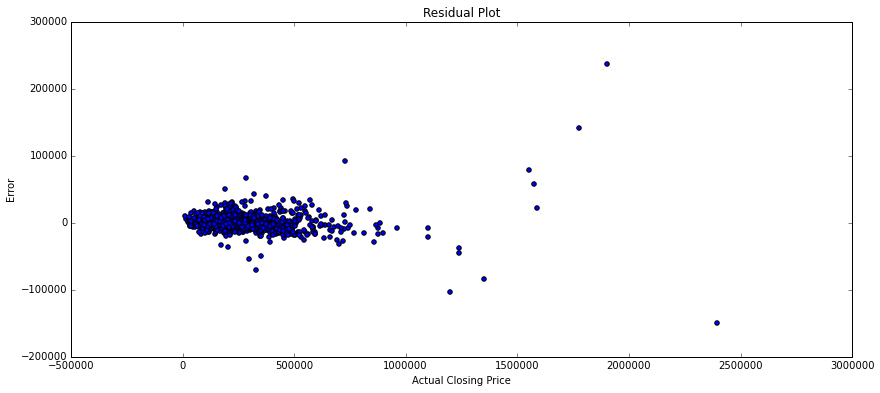

In [37]:
# Errors
plt.figure(figsize = (14, 6))
plt.scatter(y_test, predictions-y_test)
plt.title('Residual Plot')
plt.xlabel('Actual Closing Price')
plt.ylabel('Error')

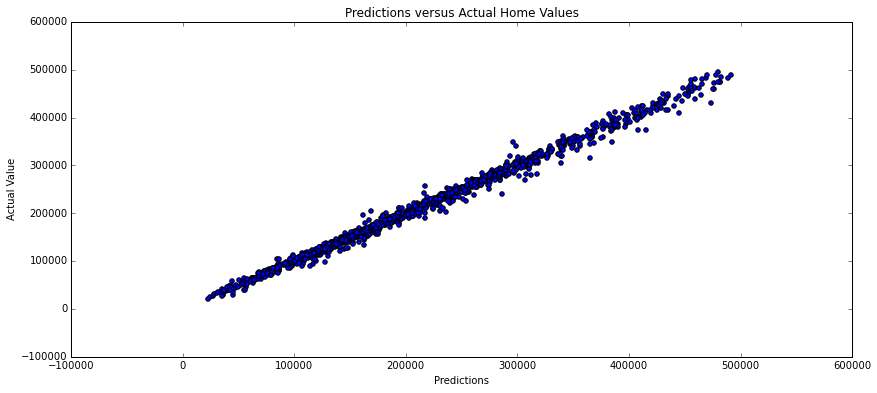

In [260]:
# Visualize Predictions

plt.figure(figsize = (14, 6))
plt.scatter(adjusted_booster_predictions, adjusted_y_test)
plt.title('Predictions versus Actual Home Values')
plt.xlabel('Predictions')
plt.ylabel('Actual Value')